In [1]:
input_dir = "input/"
images_dir = "sub_images/positive/"

nb_folds = 5
seed = 2024

print(nb_folds, seed)

!ls $input_dir
!ls $images_dir | wc

5 2024
butterfly_anomaly_train_checksums.csv  butterfly_anomaly_train_log.jsonl
butterfly_anomaly_train.csv	       images
   7598    7598  116835


In [2]:
import numpy as np
import pandas as pd
import pickle
import glob

from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
np.bool = bool

from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm

# Mine
from GCForest import gcForest # https://github.com/pylablanche/gcForest/tree/master
import utils
utils.seed_basic(seed)

!python --version

Python 3.9.21


In [3]:
filenames = glob.glob(images_dir + "/*.jpg")
print(len(filenames), filenames[:2], filenames[-2:])

original_filenames = glob.glob(input_dir + "images/**/*.jpg")
print(len(original_filenames), original_filenames[:2], original_filenames[-2:])

def get_butterfly_id(f):
    return f.split("/")[-1].split(".")[0].split("_")[0]
    
dict_original_filenames = {get_butterfly_id(f):f for f in original_filenames}

def get_original_filename(filename):
    butterfly_id = get_butterfly_id(filename)
    return dict_original_filenames.get(butterfly_id)

get_original_filename('sub_images/positive/CAM016787_3.jpg')

7598 ['sub_images/positive/CAM016787_3.jpg', 'sub_images/positive/19N2282_3.jpg'] ['sub_images/positive/CAM008980_0.jpg', 'sub_images/positive/19N0834_0.jpg']
2082 ['../input/images/hybrid/CAM016787.jpg', '../input/images/hybrid/CAM016987.jpg'] ['../input/images/non-hybrid/CAM016081.jpg', '../input/images/non-hybrid/CAM045121.jpg']


'../input/images/hybrid/CAM016787.jpg'

In [28]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

def cal_pr_auc(gt, preds):
    precision, recall, _ = precision_recall_curve(gt, preds)
    pr_auc = auc(recall, precision)
    return float(pr_auc)
    
def evaluate_prediction(scores, labels, reversed=False):
    combined = list(zip(scores, labels))
    combined = sorted(combined, key=lambda x: x[0], reverse=reversed)
    combined = np.array(combined)

    for i in range(combined.shape[0] + 1):
        ls, rs = i, combined.shape[0] - i
        preds = np.concatenate((np.zeros(ls), np.ones(rs)))
        recall = recall_score(combined[:, 1], preds, pos_label=0)
        if recall >= 0.95:
            return preds, combined[:, 1]
    
    return None, combined[:, 1]  

def evaluate(scores, labels, reversed=False):
    """Requires lower score to mean more likely to be non-hybrid,
    and higher score to mean more likely to be hybrid.
    
    If you would like this to be reversed, set reversed=True
    """
    preds, gt = evaluate_prediction(scores, labels, reversed)

    if preds is None:
        return None  
    
    h_recall = recall_score(gt, preds, pos_label=1)
    h_precision = precision_score(gt, preds, pos_label=1)
    f1 = f1_score(gt, preds, pos_label=1)
    roc_auc = roc_auc_score(gt, preds)
    acc = accuracy_score(gt, preds)

    pr_auc = cal_pr_auc(gt, preds)

    return h_recall, h_precision, f1, roc_auc, acc, pr_auc

def print_evaluation(h_recall, h_precision, f1, roc_auc, acc, pr_auc):
    print(f"""
          Hybrid-Recall: {h_recall}
          Hybrid-Precision: {h_precision}
          f1-Score: {f1}
          ROC AUC: {roc_auc}
          Accuracy: {acc},
          PR AUC: {pr_auc}
          """)

In [5]:
df_labels = pd.read_csv(input_dir + "butterfly_anomaly_train.csv")
df_labels["butterfly_id"] = df_labels["filename"].apply(lambda f: get_butterfly_id(f))
df_labels.tail()

,CAMID,file_url,hybrid_stat,split,zenodo_link,md5,subspecies,parent_subspecies_1,parent_subspecies_2,filename,butterfly_id
2077,CAM036201,https://zenodo.org/record/5561246/files/CAM036...,non-hybrid,train,https://zenodo.org/record/5561246,3e3c5d0f40fe04388e021b96d07bcdf6,11.0,NaN,NaN,CAM036201.jpg,CAM036201
2078,CAM036199,https://zenodo.org/record/5561246/files/CAM036...,non-hybrid,train,https://zenodo.org/record/5561246,4b6d73bd76cea08370537d4ccd4dc9ef,11.0,NaN,NaN,CAM036199.jpg,CAM036199
2079,CAM036198,https://zenodo.org/record/5561246/files/CAM036...,non-hybrid,train,https://zenodo.org/record/5561246,d3153f3fac8b98df506895efaf84b23d,11.0,NaN,NaN,CAM036198.jpg,CAM036198
2080,CAM036197,https://zenodo.org/record/5561246/files/CAM036...,non-hybrid,train,https://zenodo.org/record/5561246,d2cd1c4d54e84daae69c048a538a7609,11.0,NaN,NaN,CAM036197.jpg,CAM036197
2081,CAM036213,https://zenodo.org/record/5561246/files/CAM036...,non-hybrid,train,https://zenodo.org/record/5561246,fdf557fc5097a4477f3407130352aac2,11.0,NaN,NaN,CAM036213.jpg,CAM036213


In [6]:
df_labels.fillna(-1).groupby(["parent_subspecies_1", "parent_subspecies_2"])["filename"].count()

parent_subspecies_1  parent_subspecies_2
-1.0                 -1.0                   1991
 8.0                  9.0                     91
Name: filename, dtype: int64

In [7]:
df_train = pd.DataFrame({'filename': filenames})

df_train["butterfly_id"] = df_train["filename"].apply(lambda f: get_butterfly_id(f))
print(df_train.shape)

view_cols = ["butterfly_id", "hybrid_stat", "subspecies"]
# view_rows = ~df_labels["subspecies"].isna()

df_train = pd.merge(df_train, df_labels[view_cols], on="butterfly_id")
df_train["target"] = (df_train["hybrid_stat"] == "hybrid").astype(int)

print(df_train["target"].value_counts())
df_train

(7598, 2)
target
0    7241
1     357
Name: count, dtype: int64


,filename,butterfly_id,hybrid_stat,subspecies,target
0,sub_images/positive/CAM016787_3.jpg,CAM016787,hybrid,NaN,1
1,sub_images/positive/19N2282_3.jpg,19N2282,non-hybrid,8.0,0
2,sub_images/positive/19N2117_0.jpg,19N2117,non-hybrid,8.0,0
3,sub_images/positive/CS000283_1.jpg,CS000283,non-hybrid,13.0,0
4,sub_images/positive/CAM040497_1.jpg,CAM040497,non-hybrid,2.0,0
...,...,...,...,...,...
7593,sub_images/positive/CAM021071_2.jpg,CAM021071,non-hybrid,0.0,0
7594,sub_images/positive/19N2159_1.jpg,19N2159,non-hybrid,8.0,0
7595,sub_images/positive/CAM041069_1.jpg,CAM041069,non-hybrid,8.0,0
7596,sub_images/positive/CAM008980_0.jpg,CAM008980,non-hybrid,7.0,0


In [8]:
skf = StratifiedGroupKFold(n_splits=nb_folds, random_state=seed, shuffle=True)
df_folds = df_train.copy()
df_folds["fold"] = -1

for i, (train_index, test_index) in enumerate(skf.split(df_folds, df_folds["target"], df_folds["butterfly_id"])):
    df_folds.loc[test_index, "fold"] = i

df_folds.groupby(["fold"])["target"].agg(["count", "sum"])

,count,sum
fold,,
0,1509,75
1,1534,76
2,1519,71
3,1515,60
4,1521,75


In [9]:
df_folds.groupby("butterfly_id")["fold"].nunique().sort_values()

butterfly_id
15N016       1
CAM040589    1
CAM040588    1
CAM040587    1
CAM040586    1
            ..
CAM016045    1
CAM016018    1
CAM016013    1
CAM016008    1
SHM000341    1
Name: fold, Length: 2082, dtype: int64

In [10]:
import pickle

with open('workspace/bioclip_features.pickle', 'rb') as handle: # TODO: verify if it works
    features_dict = pickle.load(handle)
len(features_dict), list(features_dict.keys())[0]

(7598, 'sub_images/positive/CAM016787_3.jpg')

In [11]:
def get_features_row(row):
    filename = row["filename"]
    original_filename = get_original_filename(filename)
    features = features_dict[filename]
    return features

In [12]:
dict_models = {}

fold = 0
# if True:
run_folds = [0] # list(range(nb_folds)) + [-1]
print("run_folds:", run_folds)
for fold in run_folds:
    print("="*40)
    print( f"Processing fold {fold} ... ")
    
    df_fold_train = df_folds[df_folds["fold"] != fold].reset_index(drop=True)
    if fold >= 0:
        df_fold_val = df_folds[df_folds["fold"] == fold].reset_index(drop=True)
    else:
        df_fold_val = df_fold_train.copy()
    
    X_train = []
    for index, row in tqdm(df_fold_train.iterrows()):
        img = get_features_row(row)
        X_train.append(img.flatten())
        
    X_train = np.stack(X_train)
    print(X_train.shape) # (539, 98304)
    
    X_val = []
    for index, row in tqdm(df_fold_val.iterrows()):
        img = get_features_row(row)
        X_val.append(img.flatten())
        
    X_val = np.stack(X_val)
    print(X_val.shape) # (135, 98304)
    
    y_train = np.array(df_fold_train["target"])
    y_val = np.array(df_fold_val["target"])
    print(y_train.shape, y_val.shape)

    # model = CascadeForestClassifier(random_state=1)
    model = gcForest(shape_1X=[8,8], window=[4,6], tolerance=0.0, min_samples_mgs=10, min_samples_cascade=7)
    model.fit(X_train, y_train) # Be careful when fold==-1, train == val
    
    y_pred = model.predict_proba(X_val)
    acc = (y_pred.argmax(axis=1) == y_val).mean()
    print("\nValidation Accuracy: {:.3f} %".format(acc)) # Testing Accuracy: 82.963 %

    dict_models[fold] = {
        "model": model,
        "metrics": {
            "acc": acc,
        },
        "y_pred": y_pred,
        "y_val": y_val,
        "df_val": df_fold_val
    }
    print("="*40)

len(dict_models)

run_folds: [0]
Processing fold 0 ... 


6089it [00:00, 8490.52it/s]


(6089, 512)


1509it [00:00, 8655.82it/s]


(1509, 512)
(6089,) (1509,)
Slicing Images...
Training MGS Random Forests...
Slicing Images...
Training MGS Random Forests...


/home/moto/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Adding/Training Layer, n_layer=1
Layer validation accuracy = 0.9630541871921182
Adding/Training Layer, n_layer=2
Layer validation accuracy = 0.9622331691297209
Slicing Images...
Slicing Images...

Validation Accuracy: 0.958 %


1


Validation Accuracy: 0.958 %


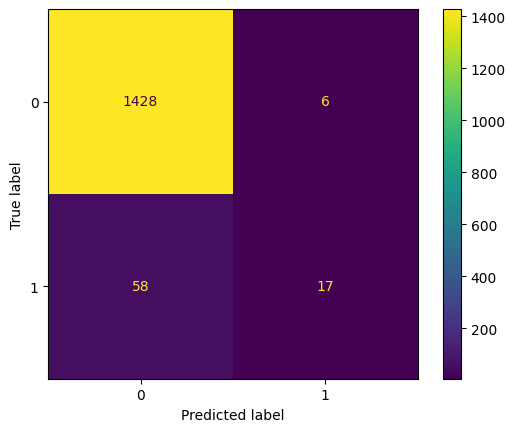

In [14]:
acc = (y_pred.argmax(axis=1) == y_val).mean()
print("\nValidation Accuracy: {:.3f} %".format(acc)) # Testing Accuracy: 82.963 %

clf_classes = list(range(2))
cm = confusion_matrix(y_val, y_pred.argmax(axis=1), labels=clf_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_classes)
disp.plot();

In [15]:
dict_models[0].keys()

fold = 0
df_show = dict_models[fold]["df_val"] # dict_keys(['model', 'metrics', 'y_pred', 'y_val', 'df_val'])
df_show["pred"] = dict_models[fold]["y_pred"].argmax(axis=1)
df_show["prob"] = dict_models[fold]["y_pred"].max(axis=1)
for i in range(2):
    df_show[i] = dict_models[fold]["y_pred"][:,i]
df_show

,filename,butterfly_id,hybrid_stat,subspecies,target,fold,pred,prob,0,1
0,sub_images/positive/CAM040596_3.jpg,CAM040596,non-hybrid,2.0,0,0,0,0.994224,0.994224,0.005776
1,sub_images/positive/CAM040572_0.jpg,CAM040572,non-hybrid,2.0,0,0,0,0.995050,0.995050,0.004950
2,sub_images/positive/CAM040241_0.jpg,CAM040241,non-hybrid,8.0,0,0,0,0.992574,0.992574,0.007426
3,sub_images/positive/CAM016078_0.jpg,CAM016078,non-hybrid,9.0,0,0,0,0.998762,0.998762,0.001238
4,sub_images/positive/CS003654_0.jpg,CS003654,non-hybrid,13.0,0,0,0,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1504,sub_images/positive/CAM040169_3.jpg,CAM040169,non-hybrid,8.0,0,0,0,0.857848,0.857848,0.142152
1505,sub_images/positive/CAM008184_3.jpg,CAM008184,non-hybrid,7.0,0,0,0,0.995792,0.995792,0.004208
1506,sub_images/positive/CAM040686_1.jpg,CAM040686,non-hybrid,2.0,0,0,0,1.000000,1.000000,0.000000
1507,sub_images/positive/CAM045130_3.jpg,CAM045130,non-hybrid,2.0,0,0,0,0.999381,0.999381,0.000619


In [16]:
df_p2 = df_show.copy()

In [17]:
df_show_agg = df_show.groupby("butterfly_id")["pred"].nunique()
print(df_show_agg.value_counts())

df_show_agg = df_show.groupby(["butterfly_id", "target"])[1].agg(["mean", "max", "std"]).reset_index()
df_show_agg

pred
1    402
2     15
Name: count, dtype: int64


,butterfly_id,target,mean,max,std
0,15N016,0,0.000712,0.001856,0.000895
1,19N0005,0,0.000000,0.000000,0.000000
2,19N0006,0,0.000138,0.000550,0.000275
3,19N0017,0,0.000177,0.000707,0.000354
4,19N0022,0,0.001702,0.006807,0.003403
...,...,...,...,...,...
412,F948,0,0.000000,0.000000,NaN
413,F968,0,0.002970,0.005941,0.004201
414,F984,0,0.000000,0.000000,0.000000
415,F998,0,0.008192,0.016384,0.011585


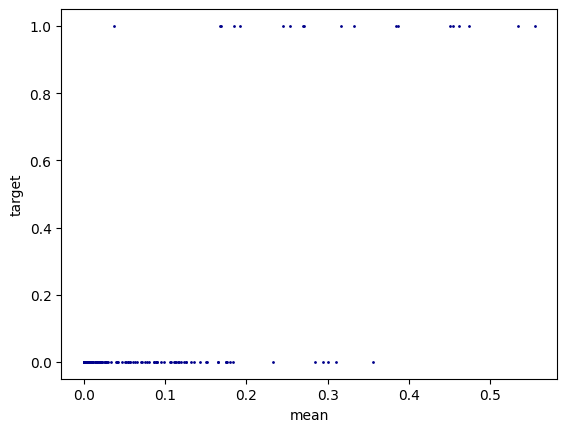

In [27]:
df_show_agg.plot.scatter(x='mean',
                         y='target',
                         c='DarkBlue', s=1);

In [29]:
rs = evaluate(scores=df_show_agg["mean"], labels=df_show_agg["target"])
rs

(np.float64(0.9473684210526315),
 np.float64(0.4864864864864865),
 np.float64(0.6428571428571429),
 np.float64(0.9498148637926473),
 0.9520383693045563,
 0.718126494536945)

In [30]:
# Your algorithm needs to generate an anomaly score for each input image: the higher the score is, 
# the more likely the input image is an anomaly (i.e., hybrid).

# The submissions are evaluated based on two metrics:
# - The true positive rate (TPR) at the true negative rate (TNR) = 95%: 
# the recall of hybrid cases, with a score threshold set to recognizing non-hybrid cases with 95% accuracy.
# - PRC AUC
                                                 
print_evaluation(*rs)


          Hybrid-Recall: 0.9473684210526315
          Hybrid-Precision: 0.4864864864864865
          f1-Score: 0.6428571428571429
          ROC AUC: 0.9498148637926473
          Accuracy: 0.9520383693045563,
          PR AUC: 0.718126494536945
          


In [31]:
cal_pr_auc(gt=df_show_agg["target"], preds=df_show_agg["mean"])

0.8161233267028387

# Save

In [23]:
dict_model_submission = {
    "model": dict_models[0]["model"]
}

with open('workspace/butterfly_models_bin.pickle', 'wb') as handle:
    pickle.dump(dict_model_submission, handle)

In [24]:
dict_models[0].keys(), type(dict_models[0]["model"])

(dict_keys(['model', 'metrics', 'y_pred', 'y_val', 'df_val']),
 GCForest.gcForest)

In [25]:
import sklearn
import transformers
sklearn.__version__, transformers.__version__

('1.4.2', '4.48.0')

In [26]:
import torch
import torchvision
torch.__version__, torchvision.__version__

('2.3.0+cu121', '0.18.0+cu121')